# Amazon Review Helpfulness Prediction

## Problem Statement

In this project, we will try to automatically predict the helpfulness of Amazon.com product reviews, specifically in
the case of home and kitchen products.

The inspiration behind this project is that the product we buy is mostly influenced by the review about the product. In most of the e-commerce platform, the most helpful reviews are displayed on the products front page.In order to differentiate reviews based on their helpfulness, Amazon has implemented an interface that allows customers to vote on whether a particular review has been helpful or unhelpful. The fraction of customers who have deemed the review helpful is displayed with the review, and  amazon uses these ratings to rank the reviews, displaying the most helpful rankings on the products front page. The drawback is that more recently written reviews are at a disadvantage since less people have voted on the helpfulness of the review. Because of this, reviews with few votes cannot be effectively ranked and will not gain visibility until they have accumulated adequate votes, which can take some time.

As a result, we would like to assess the helpfulness of reviews automatically, without having to wait for users to manually vote over the course of time. If we can do this, we would be able to give users the most relevant, helpful, and up to date reviews possible, without any delay in more helpful reviews being displayed. Moreover, such an automatic classification of reviews would be able to help in rooting out poorly written reviews lacking helpful information to other consumers.

For the problem statement, we will use the Home and Kitchen dataset which is having around 346,355 reviews. Dataset is available at JmCauley page: http://jmcauley.ucsd.edu/data/amazon/links.html

### Import and Initialization

In [1]:
# Importing the relevant dependencies
import numpy as np
import pandas as pd
import gzip
import math, time, random, datetime
import string
import os
import nltk
#nltk.download('stopwords')
from collections import defaultdict
from gensim.models import Word2Vec

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
import pickle
from sklearn.model_selection import train_test_split

In [2]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src\\utils")

In [3]:
import utility
from custom_text_preprocessing import normalize_text
from custom_transformer import ColumnExtractor, TextTFIDFVectorizer, TextWord2Vectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# folder where input data and pickle data load present
data_folder = '../data/dataLoad/'
input_folder = '../data/raw/'

### Data Loading

In [5]:
# Loading the home and kitchen dataset which is downloaded in the /data path
input_data = 'reviews_Home_and_Kitchen_5.json.gz'
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i +=1
    return pd.DataFrame.from_dict(df, orient='index')

data = getDF(input_folder + input_data)   

In [6]:
data.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"


As mentioned in the jmcauley site, belaw are the description of the fields:
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3.
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)

### Data Preprocessing 

Before selecting features from the data, need to narrow down search to those reviews that had more than 10 total reviews. The ratio of people that find it helpful is more important. This effect can disappear at small ratings (e.g 1/2) so the reviews with less than 10 ratings have been eliminated. Beyond that we also limited our search to reviews for products had at least 10 reviews, because automated helpfulness classification itself is not necessary if the given product for which the reviews are being displayed has few reviews to begin with.

#### Data Filtering 

In [7]:
# Size of the data before filtering
data.shape

(551682, 9)

In [8]:
# Filter the products which has atleast 10 reviews
groupby_product = data.groupby('asin').size()
filter_reviews = data.groupby('asin').size().values >= 10
filter_asins = groupby_product[filter_reviews].index
data_filter = data.loc[data['asin'].isin(filter_asins), :]
data_filter.shape

(462551, 9)

In [9]:
# Filter the reviews having more than 10 helpful reviews
dataset = data_filter[data_filter['helpful'].apply(lambda x: x[1] > 10)]
dataset.shape

(27477, 9)

Now our data is reduced down to 86914 product reviews. Next is deriving the helpfulness target variable.The problem statement is the classification problem that needs to be mapped to discrete class, in our case its binary classification with 2 discrete class i.e; 1/0 which map to Helpful/Not Helpful class repectively. We use the sigmoid function in order to map predicted values to probability values. This sigmoid function then maps any real value into a probability value between 0 and 1.
The sigmoid function returns a probability value between 0 and 1. This probability value is then mapped to a discrete class which is either “0” or “1”. In order to map this probability value to a discrete class (pass/fail, yes/no, true/false), we select a threshold value. This threshold value is called Decision boundary. Above this threshold value, we will map the probability values into class 1 and below which we will map values into class 0.

Mathematically, it can be expressed as follows:-

                p ≥ 0.5 => class = 1

                p < 0.5 => class = 0 


Generally, the decision boundary is set to 0.5. So, if the probability value is 0.8 (> 0.5), we will map this observation to class 1. Similarly, if the probability value is 0.2 (< 0.5), we will map this observation to class 0.

We will also build custom features which will help in predicting the helpfulness further.

#### Deriving Helpfulness Target variable from features 

In [10]:
dataset['helpful_ratings'] = dataset['helpful'].apply(lambda x: x[0])
dataset['total_ratings'] = dataset['helpful'].apply(lambda x: x[1])

dataset.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_ratings,total_ratings
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013",26,27


In [11]:
dataset.describe()

,overall,unixReviewTime,helpful_ratings,total_ratings
count,27477.000000,2.747700e+04,27477.000000,27477.000000
mean,3.853769,1.261137e+09,47.941988,52.304982
std,1.447439,9.132063e+07,339.326083,344.390836
min,1.000000,9.572256e+08,0.000000,11.000000
25%,3.000000,1.201651e+09,12.000000,14.000000
50%,5.000000,1.282090e+09,19.000000,22.000000
75%,5.000000,1.331251e+09,38.000000,43.000000
max,5.000000,1.405642e+09,52176.000000,52861.000000


Lets checkout the extreme total ratings. It looks like an outlier.

In [12]:
dataset[dataset.helpful_ratings == dataset.helpful_ratings.max()]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_ratings,total_ratings
396128,A1TTA1UUGY4WY4,B0047E0EII,SW3K,"[52176, 52861]",For decades I have been trying to come up with...,5.0,"No more winning for you, Mr. Banana!",1299110400,"03 3, 2011",52176,52861


In [13]:
dataset = dataset.drop(dataset.index[dataset.helpful_ratings == dataset.helpful_ratings.max()])

In [14]:
dataset.describe()

,overall,unixReviewTime,helpful_ratings,total_ratings
count,27476.000000,2.747600e+04,27476.000000,27476.000000
mean,3.853727,1.261136e+09,46.044766,50.382989
std,1.447449,9.132200e+07,127.439043,130.782279
min,1.000000,9.572256e+08,0.000000,11.000000
25%,3.000000,1.201651e+09,12.000000,14.000000
50%,5.000000,1.282090e+09,19.000000,22.000000
75%,5.000000,1.331251e+09,38.000000,43.000000
max,5.000000,1.405642e+09,6128.000000,6174.000000


Lets check the count of reviews greater than 1000 and remove them if they are making the distribution a bit more skewed

In [15]:
dataset[dataset.total_ratings > 1000].count()

reviewerID         68
asin               68
reviewerName       68
helpful            68
reviewText         68
overall            68
summary            68
unixReviewTime     68
reviewTime         68
helpful_ratings    68
total_ratings      68
dtype: int64

The count is very less. Lets remove these and check the distribution again

In [16]:
dataset = dataset.drop(dataset.index[dataset.total_ratings > 1000])

In [17]:
dataset.describe()

,overall,unixReviewTime,helpful_ratings,total_ratings
count,27408.000000,2.740800e+04,27408.000000,27408.000000
mean,3.852415,1.261193e+09,41.793126,46.024701
std,1.447970,9.136917e+07,75.977905,78.878631
min,1.000000,9.572256e+08,0.000000,11.000000
25%,3.000000,1.201738e+09,12.000000,14.000000
50%,5.000000,1.282176e+09,19.000000,22.000000
75%,5.000000,1.331359e+09,38.000000,42.000000
max,5.000000,1.405642e+09,976.000000,996.000000


We will try 2 ways of calculating the optimal threshold.One with the normal dataset. Another applying the threshold function on  the svaled Dataset.Let's set aside another copy of the dataset which we will use for scaling the dataset

In [18]:
scaled_df = dataset.copy()

In [19]:
from utility import scaleColumns
scaled_df = scaleColumns(scaled_df,['helpful_ratings','total_ratings'])

In [20]:
scaled_df.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_ratings,total_ratings
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013",0.032787,0.028426


In [21]:
# This funcion will get the helpfulness rating based on certain threshold and total and helpful ratings count
def getHelpfulness(input_dataset, threshold):
    threshold=threshold
    input_dataset.loc[:, 'isHelpful'] = np.where(input_dataset['helpful_ratings']/input_dataset['total_ratings'] > threshold, 1, 0)
    
    return input_dataset

In [22]:
def getOptimalThreshold(input_dataset):
    
    # Lets start with threshold value as 0.5 assuming the dataset is uniformly distributed
    threshold = 0.5
        
    for x in range(1,6):
        # Call getHelpfulness method an dcheck how the data is distributed in case of 0.5 threshold
        print('Threshold : %f' %threshold)
        input_dataset = getHelpfulness(input_dataset, threshold)
        frequency = input_dataset['isHelpful'].value_counts()
        print('Frequency of 0 value : %f' %frequency.loc[0])
        print('Frequency of 1 value : %f' %frequency.loc[1])
        if(frequency.loc[0]/(frequency[0]+frequency[1]) < 0.5):
            threshold = threshold + 0.1
        else:
            threshold = threshold - 0.1

In [23]:
getOptimalThreshold(dataset)

Threshold : 0.500000
Frequency of 0 value : 1613.000000
Frequency of 1 value : 25795.000000
Threshold : 0.600000
Frequency of 0 value : 2032.000000
Frequency of 1 value : 25376.000000
Threshold : 0.700000
Frequency of 0 value : 2915.000000
Frequency of 1 value : 24493.000000
Threshold : 0.800000
Frequency of 0 value : 4920.000000
Frequency of 1 value : 22488.000000
Threshold : 0.900000
Frequency of 0 value : 10524.000000
Frequency of 1 value : 16884.000000


In [24]:
getOptimalThreshold(scaled_df)

Threshold : 0.500000
Frequency of 0 value : 25274.000000
Frequency of 1 value : 2134.000000
Threshold : 0.400000
Frequency of 0 value : 25267.000000
Frequency of 1 value : 2141.000000
Threshold : 0.300000
Frequency of 0 value : 25260.000000
Frequency of 1 value : 2148.000000
Threshold : 0.200000
Frequency of 0 value : 25251.000000
Frequency of 1 value : 2157.000000
Threshold : 0.100000
Frequency of 0 value : 25240.000000
Frequency of 1 value : 2168.000000


Scaling the dataframe doesnt help much. So lets go without scaling the columns value.

Let's try to compare how the model performs in 3 of the threshold frquency i.e; 0.8, 0.85, 0.9 and come to conclusion which one is best and doesn't overfit as well.

In [25]:
dataset_threshold_08 = getHelpfulness(dataset, threshold=0.8)

In [26]:
dataset_threshold_08 = dataset.drop(columns = ['helpful', 'helpful_ratings', 'total_ratings'], axis=1)

In [27]:
display(dataset_threshold_08.groupby('isHelpful').count())

,reviewerID,asin,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime
isHelpful,,,,,,,,
0,5154,5154,5112,5154,5154,5154,5154,5154
1,22254,22254,22247,22254,22254,22254,22254,22254


In [28]:
dataset_threshold_08 = dataset_threshold_08.reset_index(drop=True)

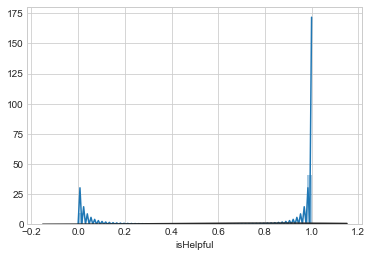

In [29]:
from scipy.stats import norm, skew

# Lets explore the distribution of the helpfulness target variable
sns.distplot(dataset_threshold_08['isHelpful'], fit=norm)

In [30]:
# dataset_threshold_085
dataset_threshold_085 = getHelpfulness(dataset, threshold=0.85)
dataset_threshold_085 = dataset.drop(columns = ['helpful', 'helpful_ratings', 'total_ratings'], axis=1)
display(dataset_threshold_085.groupby('isHelpful').count())

,reviewerID,asin,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime
isHelpful,,,,,,,,
0,7560,7560,7516,7560,7560,7560,7560,7560
1,19848,19848,19843,19848,19848,19848,19848,19848


In [31]:
dataset_threshold_085 = dataset_threshold_085.reset_index(drop=True)

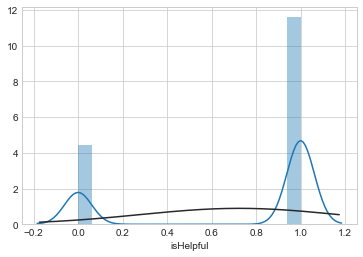

In [32]:
# Lets explore the distribution of the helpfulness target variable
sns.distplot(dataset_threshold_085['isHelpful'], fit=norm)

In [33]:
#dataset_threshold_09
dataset_threshold_09 = getHelpfulness(dataset, threshold=0.9)
dataset_threshold_09 = dataset.drop(columns = ['helpful', 'helpful_ratings', 'total_ratings'], axis=1)
display(dataset_threshold_09.groupby('isHelpful').count())

,reviewerID,asin,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime
isHelpful,,,,,,,,
0,10715,10715,10671,10715,10715,10715,10715,10715
1,16693,16693,16688,16693,16693,16693,16693,16693


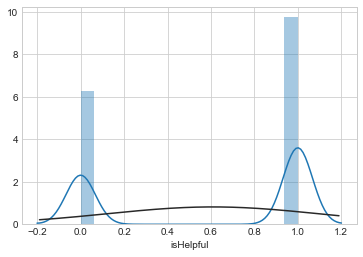

In [34]:
dataset_threshold_09 = dataset_threshold_09.reset_index(drop=True)

# Lets explore the distribution of the helpfulness target variable
sns.distplot(dataset_threshold_09['isHelpful'], fit=norm)

In [35]:
#Lets save this threshold datasets for future use
pickle.dump(dataset_threshold_08, open(input_folder+'dataset_threshold_08.p', 'wb'))
pickle.dump(dataset_threshold_085, open(input_folder+'dataset_threshold_085.p', 'wb'))
pickle.dump(dataset_threshold_09, open(input_folder+'dataset_threshold_09.p', 'wb'))

##### Custom Feature Extraction 

In [36]:
# This function will get all the customised features
def getCustomFeatures(dataset):
    start = time.time()
    
    dataset = utility.getReviewTimeDifferenceFromMin(dataset)
    dataset = utility.countReviewSentence(dataset)
    dataset = utility.count_characters(dataset)
    dataset = utility.readability(dataset)
    dataset = utility.drop_extra_features(dataset)
    
    end = time.time()
    print('Total time to derive the custom features {:4f} seconds'.format(end - start))
    return dataset

##### Defining Text Normalizer 

In [37]:
#def get_normalize_text_data(run='train'):
def get_normalize_text_data(dataset):
    start = time.time()
    dataset['normalize_review_text'] = dataset['reviewText'].apply(lambda x: normalize_text(x))
    dataset = dataset.drop(columns=['reviewText'])
    end = time.time()
    
    print('Total time to normalize the text data {:4f} seconds'.format(end - start))
    return dataset

##### Feature Aggregation

In [38]:
#Here we will generate Custom Features for the 3 threshold dataset dataset_threshold_08, dataset_threshol_085, dataset_threshold_09

#Generate the custom features for dataset_threshold_08
dataset_threshold_08 = getCustomFeatures(dataset_threshold_08)
# Generate the normalize text feature for dataset_threshold_08
dataset_threshold_08 = get_normalize_text_data(dataset_threshold_08)
dataset_threshold_08.head(1)

Total time to derive the custom features 10.968119 seconds
Total time to normalize the text data 29.713542 seconds


,isHelpful,review_first_diff,reviewReadability,normalize_review_text
0,1,640.0,12.653924,shortage pop recipes available free web purcha...


In [39]:
#Generate the custom features for dataset_threshold_085
dataset_threshold_085 = getCustomFeatures(dataset_threshold_085)
# Generate the normalize text feature for dataset_threshold_085
dataset_threshold_085 = get_normalize_text_data(dataset_threshold_085)
dataset_threshold_085.head(1)

Total time to derive the custom features 10.828627 seconds
Total time to normalize the text data 29.453457 seconds


,isHelpful,review_first_diff,reviewReadability,normalize_review_text
0,1,640.0,12.653924,shortage pop recipes available free web purcha...


In [40]:
#Generate the custom features for dataset_threshold_09
dataset_threshold_09 = getCustomFeatures(dataset_threshold_09)
# Generate the normalize text feature for dataset_threshold_09
dataset_threshold_09 = get_normalize_text_data(dataset_threshold_09)
dataset_threshold_09.head(1)

Total time to derive the custom features 11.768158 seconds
Total time to normalize the text data 28.136459 seconds


,isHelpful,review_first_diff,reviewReadability,normalize_review_text
0,1,640.0,12.653924,shortage pop recipes available free web purcha...


##### Defining the Pipeline

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


NUM_FEATURES = ['review_first_diff', 'reviewReadability']
TEXT_FEATURE = ['normalize_review_text']

process_and_join_features_tfidf = FeatureUnion(
                            transformer_list=[
                                ('numeric_feaures', Pipeline([
                                    ('selector', ColumnExtractor(NUM_FEATURES)), 
                                    ('scale', StandardScaler())
                                ])),
                                ('text_features', Pipeline([
                                    ('selector', ColumnExtractor(TEXT_FEATURE)),
                                    ('vectorizer',TextTFIDFVectorizer())
                                ]))
                            ])


process_and_join_features_word2vec = FeatureUnion(
                            transformer_list=[
                                ('numeric_feaures', Pipeline([
                                    ('selector', ColumnExtractor(NUM_FEATURES)), 
                                    ('scale', StandardScaler())
                                ])),
                                ('text_features', Pipeline([
                                    ('selector', ColumnExtractor(TEXT_FEATURE)),
                                    ('vectorizer',TextWord2Vectorizer())
                                ]))
                            ])

pipe_lr_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_dt_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', DecisionTreeClassifier(random_state=42))
                ])
pipe_randomforest_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', RandomForestClassifier(random_state=42))
                ])
pipe_adaboost_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', AdaBoostClassifier(random_state=42))
                ])

pipe_lr_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_dt_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', DecisionTreeClassifier(random_state=42))
                ])
pipe_randomforest_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', RandomForestClassifier(random_state=42))
                ])
pipe_adaboost_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', AdaBoostClassifier(random_state=42))
                ])


#### Select Base Model 

In this section, we will train the base models for all the 3 frequency dataset selected and saving the results in the dataframe for comparison

In [42]:
from sklearn.metrics import roc_auc_score

def train_predict_pipeline(pipeline, dataset):
    
    X_columns = dataset[['review_first_diff', 'reviewReadability', 'normalize_review_text']]
    y_columns = dataset[['isHelpful']]
    
    #Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_columns, y_columns, test_size=0.33, random_state=42)
    
    #Fit the training data to the pipeline
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    
    #Evaluate model
    p_pred_test = pipeline.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, p_pred_test)
    
    print('Test set accuracy score: %.3f ' % auc_test)
    
    return auc_test

In [43]:
# List of pipelines used in base mode evaluation
clf_pipeline = [pipe_lr_tfidf, pipe_dt_tfidf, pipe_randomforest_tfidf, pipe_adaboost_tfidf, pipe_lr_word2vec, pipe_dt_word2vec,
                pipe_randomforest_word2vec, pipe_adaboost_word2vec]

clf_dict = {0: 'TF-IDF Logistic Regression', 1: 'TF-IDF Decision Tree', 2: 'TF-IDF Random Forest', 3: 'TF-IDF Adaboost', 4: 'Word2Vec Logistic Regression',
             5: 'Word2Vec Decision Tree', 6: 'Word2Vec Random Forest', 7: 'Word2Vec Adaboost'}

In [44]:
# List of datasets
datasets = [dataset_threshold_08, dataset_threshold_085, dataset_threshold_09]
datasets_dict = {0: 'Dataset Threshold 0.8', 1: 'Dataset Threshold 0.85', 2: 'Dataset Threshold 0.9'} 

In [45]:
results = []
for dataset_idx, dataset in enumerate(datasets):
    print('Started training on %s dataset' % datasets_dict[dataset_idx])
    for idx, clf_pipe in enumerate(clf_pipeline):
        print('Predicting test accuracy using : %s' % clf_dict[idx])
        start = time.time()
        auc_result = train_predict_pipeline(clf_pipe, dataset)    
        end = time.time()

        print('Total time to train and predict : {} is {:4f} seconds'.format(clf_dict[idx], (end-start)))
        results.append([datasets_dict[dataset_idx], clf_dict[idx], auc_result, (end-start)])
    print('Completed training on %s dataset' % datasets_dict[dataset_idx])

Started training on Dataset Threshold 0.8 dataset
Predicting test accuracy using : TF-IDF Logistic Regression
Test set accuracy score: 0.748 
Total time to train and predict : TF-IDF Logistic Regression is 12.005636 seconds
Predicting test accuracy using : TF-IDF Decision Tree
Test set accuracy score: 0.555 
Total time to train and predict : TF-IDF Decision Tree is 38.585371 seconds
Predicting test accuracy using : TF-IDF Random Forest
Test set accuracy score: 0.704 
Total time to train and predict : TF-IDF Random Forest is 71.546725 seconds
Predicting test accuracy using : TF-IDF Adaboost
Test set accuracy score: 0.702 
Total time to train and predict : TF-IDF Adaboost is 25.637593 seconds
Predicting test accuracy using : Word2Vec Logistic Regression
Test set accuracy score: 0.667 
Total time to train and predict : Word2Vec Logistic Regression is 137.971315 seconds
Predicting test accuracy using : Word2Vec Decision Tree
Test set accuracy score: 0.550 
Total time to train and predict :

In [46]:
df_results = pd.DataFrame(results, columns=['Dataset', 'Feature Representation', 'Accuracy', 'Total time'])
df_results.sort_values(by=['Accuracy'], ascending=False)

,Dataset,Feature Representation,Accuracy,Total time
0,Dataset Threshold 0.8,TF-IDF Logistic Regression,0.748464,12.005636
8,Dataset Threshold 0.85,TF-IDF Logistic Regression,0.713934,12.119960
2,Dataset Threshold 0.8,TF-IDF Random Forest,0.703938,71.546725
3,Dataset Threshold 0.8,TF-IDF Adaboost,0.701953,25.637593
10,Dataset Threshold 0.85,TF-IDF Random Forest,0.684589,79.402707
11,Dataset Threshold 0.85,TF-IDF Adaboost,0.682472,26.542211
16,Dataset Threshold 0.9,TF-IDF Logistic Regression,0.678812,11.829845
6,Dataset Threshold 0.8,Word2Vec Random Forest,0.673182,181.640744
4,Dataset Threshold 0.8,Word2Vec Logistic Regression,0.667467,137.971315
18,Dataset Threshold 0.9,TF-IDF Random Forest,0.663285,82.035155


Based on the above test accuracy, dataset having threshold frequency 0.8 performs better than rest. We will do a cross-validation using GridSearchCV over TFIDF Logistic Regression, Random Forest and Adaboost. And as we know the dataset Before doing this GridSearchCV, lets split the dataset_threshold_08 into train and test data

In [47]:
X_columns = dataset_threshold_08[['review_first_diff', 'reviewReadability', 'normalize_review_text']]
y_columns = dataset_threshold_08[['isHelpful']]

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_columns, y_columns, test_size=0.33, random_state=42)

In [49]:
from sklearn.metrics import accuracy_score,precision_score
from plotting import report, plot_roc

def perform_model_optimization(grids, grid_dict):
    # Fit the grid search objects
    print('Performing model optimizations...')
    best_acc = 0.0
    best_clf = 0
    best_gs = ''
    for idx, gs in enumerate(grids):
        start = time.time()
        print('\nEstimator: %s' % grid_dict[idx])
        # Fit grid search
        gs.fit(X_train, y_train)
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred = gs.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set precision score for best params: %.3f ' % accuracy_score(y_test, y_pred))
        print('Reports :')
        report(y_test, y_pred)
        plot_roc(y_test, y_pred)
        # Track best (highest test accuracy) model
        if accuracy_score(y_test, y_pred) > best_acc:
            best_acc = accuracy_score(y_test, y_pred)
            best_gs = gs
            best_clf = idx
        end= time.time()
        print('Total time to perform model optimization {} : {:4f}'.format(grid_dict[idx], (end - start)))
    print('\nClassifier with best test set precision: %s' % grid_dict[best_clf])
    return (best_clf,best_gs)

In [50]:
from sklearn.model_selection import GridSearchCV

# Set grid search params
param_range = [2, 4, 6, 8, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}]
grid_params_dt=[{'clf__min_samples_split' : param_range[1:],
                 'clf__max_depth': param_range}]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_adaboost = [{'clf__learning_rate': [0.01,0.05,0.1,0.3,1],
        'clf__n_estimators': [50, 100]}]


In [52]:
jobs = -1

gs_lr_tfidf = GridSearchCV(estimator=pipe_lr_tfidf,
                     param_grid=grid_params_lr,
                     scoring='accuracy',cv=5)

gs_dt_tfidf = GridSearchCV(estimator=pipe_dt_tfidf,
                    param_grid=grid_params_dt,
                    scoring='accuracy',
                    cv=5, n_jobs=jobs)
gs_rf_tfidf = GridSearchCV(estimator=pipe_randomforest_tfidf,
                    param_grid=grid_params_rf,
                    scoring='accuracy',
                    cv=5, n_jobs=jobs)
gs_adaboost_tfidf = GridSearchCV(estimator=pipe_adaboost_tfidf,
                    param_grid=grid_params_adaboost,
                    scoring='accuracy',
                    cv=5, n_jobs=jobs)

In [56]:
# List of pipelines for ease of iteration
grids = [gs_lr_tfidf, gs_rf_tfidf, gs_adaboost_tfidf]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'TF-IDF Logistic Regression', 1: 'TF-IDF RandomForest', 2: 'TF-IDF Adaboost'}


Performing model optimizations...

Estimator: TF-IDF Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.820
Test set precision score for best params: 0.823 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.60      0.16      0.25      1694
  notHelpful       0.83      0.98      0.90      7351

    accuracy                           0.82      9045
   macro avg       0.72      0.57      0.57      9045
weighted avg       0.79      0.82      0.78      9045



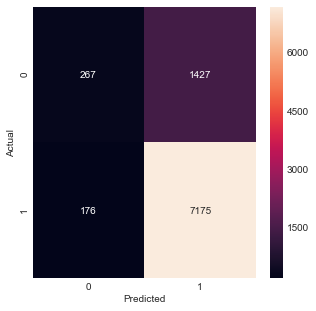

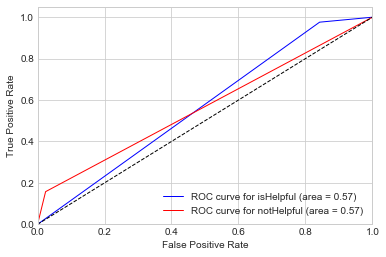

Total time to perform model optimization TF-IDF Logistic Regression : 195.080725

Estimator: TF-IDF RandomForest
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 4}
Best training accuracy: 0.812
Test set precision score for best params: 0.813 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.00      0.00      0.00      1694
  notHelpful       0.81      1.00      0.90      7351

    accuracy                           0.81      9045
   macro avg       0.41      0.50      0.45      9045
weighted avg       0.66      0.81      0.73      9045



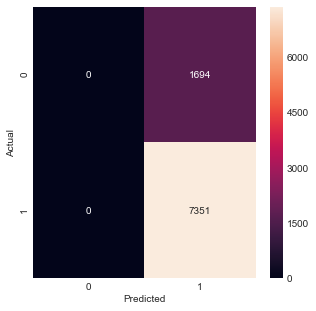

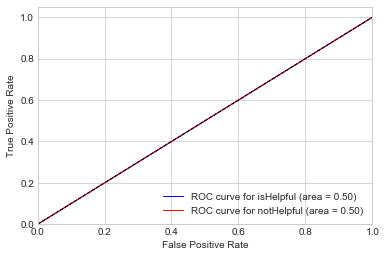

Total time to perform model optimization TF-IDF RandomForest : 473.280175

Estimator: TF-IDF Adaboost
Best params: {'clf__learning_rate': 0.3, 'clf__n_estimators': 100}
Best training accuracy: 0.813
Test set precision score for best params: 0.815 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.76      0.02      0.03      1694
  notHelpful       0.82      1.00      0.90      7351

    accuracy                           0.81      9045
   macro avg       0.79      0.51      0.46      9045
weighted avg       0.80      0.81      0.74      9045



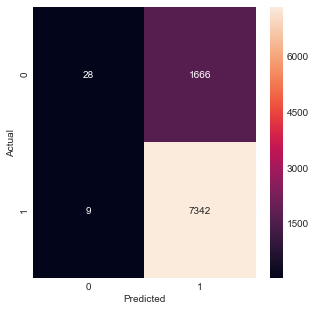

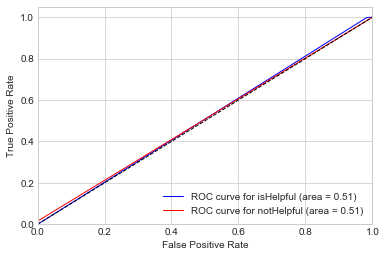

Total time to perform model optimization TF-IDF Adaboost : 287.434458

Classifier with best test set precision: TF-IDF Logistic Regression


(0, GridSearchCV(cv=5, error_score=nan,
              estimator=Pipeline(memory=None,
                                 steps=[('union',
                                         FeatureUnion(n_jobs=None,
                                                      transformer_list=[('numeric_feaures',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('selector',
                                                                                          <custom_transformer.ColumnExtractor object at 0x000001F9C0196A58>),
                                                                                         ('scale',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
              

In [57]:
perform_model_optimization(grids, grid_dict)

Based on the classification report printed above, though we have high precision or accuracy of about 80%,still its not properly build as the ratio of helpfulness and not helpfulness data is skewed with high number of helpfulness label data  compared to not helpful data. In this case we will perform over-sampling of minority data(not helpful data) so that the data distribution is symmetric using SMOTE. We will select TF-IDF Logistic Regression, Adaboost Classifier and RandomForest Classifier as this 2 model performed quite good and percision is almost close to each other

In [62]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

pipe_lr_tfidf_over_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', RandomOverSampler(random_state=42)),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_lr_tfidf_smote_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', SMOTE(random_state=42)),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_lr_tfidf_under_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', RandomUnderSampler(random_state=42)),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_adaboost_tfidf_over_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', RandomOverSampler(random_state=42)),
                   ('clf', AdaBoostClassifier(random_state=42))
                ])
pipe_adaboost_tfidf_smote_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', SMOTE(random_state=42)),
                   ('clf', AdaBoostClassifier(random_state=42))
                ])
pipe_adaboost_tfidf_under_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', RandomUnderSampler(random_state=42)),
                   ('clf', AdaBoostClassifier(random_state=42))
                ])
pipe_rf_tfidf_over_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', RandomOverSampler(random_state=42)),
                   ('clf', RandomForestClassifier(random_state=42))
                ])
pipe_rf_tfidf_smote_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', SMOTE(random_state=42)),
                   ('clf', RandomForestClassifier(random_state=42))
                ])
pipe_rf_tfidf_under_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', RandomUnderSampler(random_state=42)),
                   ('clf', RandomForestClassifier(random_state=42))
                ])

In [63]:
gs_lr_tfidf_over_sampling = GridSearchCV(estimator=pipe_lr_tfidf_over_sampling,
                     param_grid=grid_params_lr,
                     scoring='accuracy',cv=5)
gs_lr_tfidf_smote_sampling = GridSearchCV(estimator=pipe_lr_tfidf_smote_sampling,
                     param_grid=grid_params_lr,
                     scoring='accuracy',cv=5)
gs_lr_tfidf_under_sampling = GridSearchCV(estimator=pipe_lr_tfidf_under_sampling,
                     param_grid=grid_params_lr,
                     scoring='accuracy',cv=5)
gs_adaboost_tfidf_over_sampling = GridSearchCV(estimator=pipe_adaboost_tfidf_over_sampling,
                     param_grid=grid_params_adaboost,
                     scoring='accuracy',cv=5)
gs_adaboost_tfidf_smote_sampling = GridSearchCV(estimator=pipe_adaboost_tfidf_smote_sampling,
                     param_grid=grid_params_adaboost,
                     scoring='accuracy',cv=5)
gs_adaboost_tfidf_under_sampling = GridSearchCV(estimator=pipe_adaboost_tfidf_under_sampling,
                     param_grid=grid_params_adaboost,
                     scoring='accuracy',cv=5)
gs_rf_tfidf_over_sampling = GridSearchCV(estimator=pipe_rf_tfidf_over_sampling,
                     param_grid=grid_params_rf,
                     scoring='accuracy',cv=5)
gs_rf_tfidf_smote_sampling = GridSearchCV(estimator=pipe_rf_tfidf_smote_sampling,
                     param_grid=grid_params_rf,
                     scoring='accuracy',cv=5)
gs_rf_tfidf_under_sampling = GridSearchCV(estimator=pipe_rf_tfidf_under_sampling,
                     param_grid=grid_params_rf,
                     scoring='accuracy',cv=5)

In [60]:
# List of pipelines for ease of iteration
grids_sampling = [gs_lr_tfidf_over_sampling, gs_lr_tfidf_under_sampling, gs_lr_tfidf_smote_sampling, gs_adaboost_tfidf_over_sampling,
                  gs_adaboost_tfidf_under_sampling, gs_adaboost_tfidf_smote_sampling, gs_rf_tfidf_over_sampling, gs_rf_tfidf_under_sampling,
                 gs_rf_tfidf_smote_sampling]

# Dictionary of pipelines and classifier types for ease of reference
grid_sampling_dict = {0: 'Random Oversampling TF-IDF Logistic Regression', 1: 'Random Undersampling TF-IDF Logistic Regression',
                      2: 'SMOTE Oversampling TF-IDF Logistic Regression', 3: 'Random Oversampling TF-IDF Adaboost Classifier',
                      4: 'Random Undersampling TF-IDF Adaboost Classifier', 5: 'SMOTE Oversampling TF-IDF Adaboost Classifier',
                      6: 'Random Oversampling TF-IDF RandomForest Classifier', 7: 'Random Undersampling TF-IDF RandomForest Classifier',
                      8: 'SMOTE Oversampling TF-IDF RandomForest Classifier' }


Performing model optimizations...

Estimator: Random Oversampling TF-IDF Logistic Regression
Best params: {'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.708
Test set precision score for best params: 0.706 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.35      0.64      0.45      1694
  notHelpful       0.90      0.72      0.80      7351

    accuracy                           0.71      9045
   macro avg       0.62      0.68      0.62      9045
weighted avg       0.79      0.71      0.73      9045



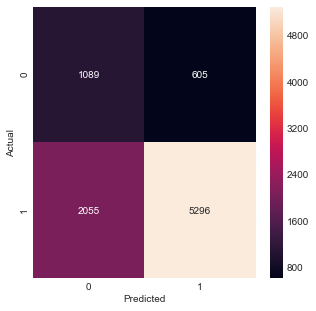

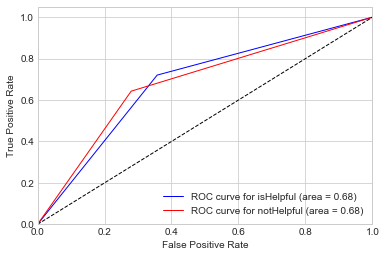

Total time to perform model optimization Random Oversampling TF-IDF Logistic Regression : 209.075914

Estimator: Random Undersampling TF-IDF Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.681
Test set precision score for best params: 0.691 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.33      0.66      0.44      1694
  notHelpful       0.90      0.70      0.79      7351

    accuracy                           0.69      9045
   macro avg       0.62      0.68      0.61      9045
weighted avg       0.79      0.69      0.72      9045



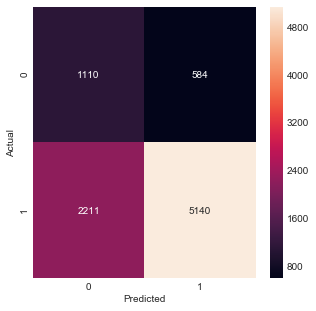

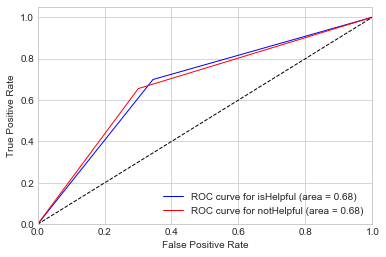

Total time to perform model optimization Random Undersampling TF-IDF Logistic Regression : 190.435521

Estimator: SMOTE Oversampling TF-IDF Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.705
Test set precision score for best params: 0.708 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.35      0.66      0.46      1694
  notHelpful       0.90      0.72      0.80      7351

    accuracy                           0.71      9045
   macro avg       0.63      0.69      0.63      9045
weighted avg       0.80      0.71      0.74      9045



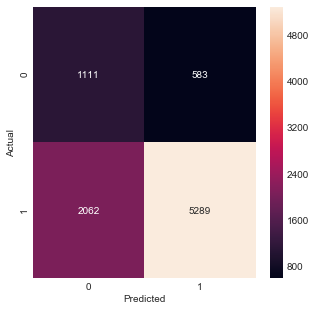

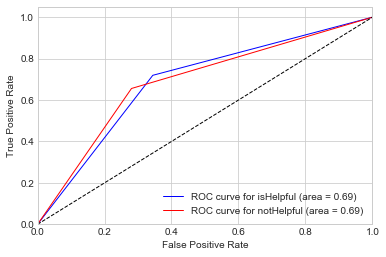

Total time to perform model optimization SMOTE Oversampling TF-IDF Logistic Regression : 226.284942

Estimator: Random Oversampling TF-IDF Adaboost Classifier
Best params: {'clf__learning_rate': 0.3, 'clf__n_estimators': 100}
Best training accuracy: 0.653
Test set precision score for best params: 0.647 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.30      0.67      0.42      1694
  notHelpful       0.89      0.64      0.75      7351

    accuracy                           0.65      9045
   macro avg       0.60      0.66      0.58      9045
weighted avg       0.78      0.65      0.68      9045



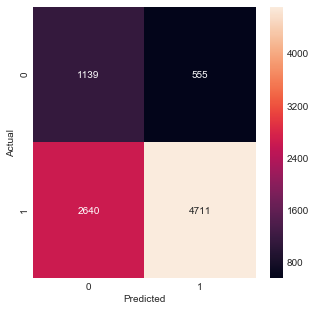

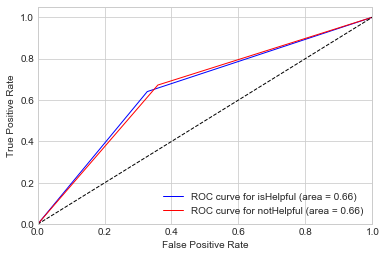

Total time to perform model optimization Random Oversampling TF-IDF Adaboost Classifier : 1364.039046

Estimator: Random Undersampling TF-IDF Adaboost Classifier
Best params: {'clf__learning_rate': 0.3, 'clf__n_estimators': 100}
Best training accuracy: 0.633
Test set precision score for best params: 0.637 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.30      0.69      0.42      1694
  notHelpful       0.90      0.63      0.74      7351

    accuracy                           0.64      9045
   macro avg       0.60      0.66      0.58      9045
weighted avg       0.79      0.64      0.68      9045



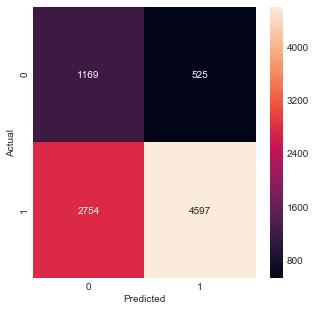

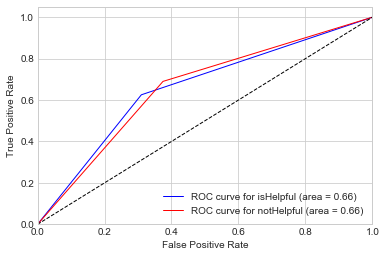

Total time to perform model optimization Random Undersampling TF-IDF Adaboost Classifier : 453.877493

Estimator: SMOTE Oversampling TF-IDF Adaboost Classifier
Best params: {'clf__learning_rate': 1, 'clf__n_estimators': 100}
Best training accuracy: 0.708
Test set precision score for best params: 0.708 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.32      0.48      0.38      1694
  notHelpful       0.86      0.76      0.81      7351

    accuracy                           0.71      9045
   macro avg       0.59      0.62      0.59      9045
weighted avg       0.76      0.71      0.73      9045



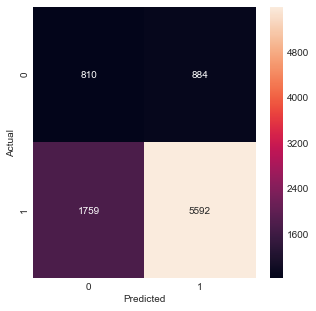

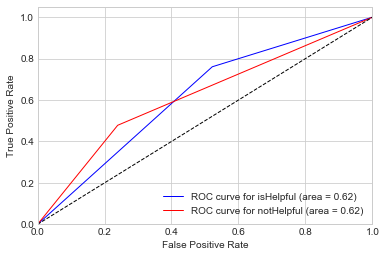

Total time to perform model optimization SMOTE Oversampling TF-IDF Adaboost Classifier : 31766.617711

Estimator: Random Oversampling TF-IDF RandomForest Classifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 4}
Best training accuracy: 0.696
Test set precision score for best params: 0.694 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.33      0.60      0.42      1694
  notHelpful       0.89      0.72      0.79      7351

    accuracy                           0.69      9045
   macro avg       0.61      0.66      0.61      9045
weighted avg       0.78      0.69      0.72      9045



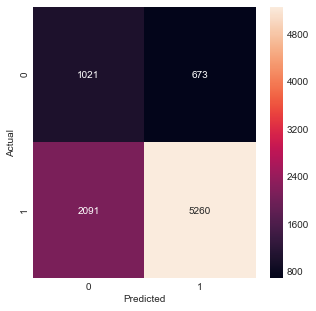

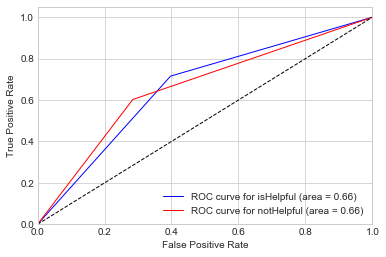

Total time to perform model optimization Random Oversampling TF-IDF RandomForest Classifier : 1687.795202

Estimator: Random Undersampling TF-IDF RandomForest Classifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 6}
Best training accuracy: 0.647
Test set precision score for best params: 0.657 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.31      0.66      0.42      1694
  notHelpful       0.89      0.66      0.76      7351

    accuracy                           0.66      9045
   macro avg       0.60      0.66      0.59      9045
weighted avg       0.78      0.66      0.69      9045



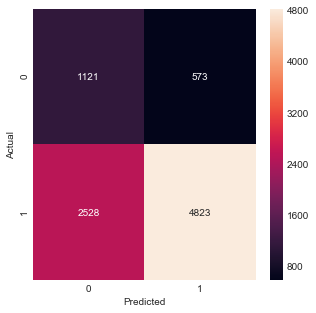

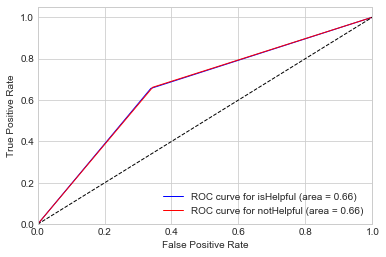

Total time to perform model optimization Random Undersampling TF-IDF RandomForest Classifier : 1204.443740

Estimator: SMOTE Oversampling TF-IDF RandomForest Classifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 6}
Best training accuracy: 0.738
Test set precision score for best params: 0.731 
Reports :
              precision    recall  f1-score   support

   isHelpful       0.29      0.30      0.29      1694
  notHelpful       0.84      0.83      0.83      7351

    accuracy                           0.73      9045
   macro avg       0.56      0.56      0.56      9045
weighted avg       0.73      0.73      0.73      9045



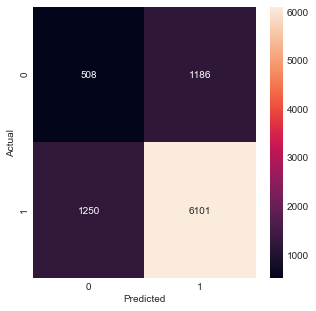

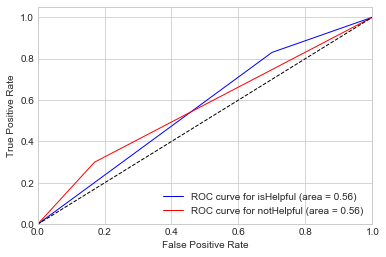

Total time to perform model optimization SMOTE Oversampling TF-IDF RandomForest Classifier : 2207.294500

Classifier with best test set precision: SMOTE Oversampling TF-IDF RandomForest Classifier


In [61]:
best_clf,best_gs = perform_model_optimization(grids_sampling, grid_sampling_dict)

In [64]:
from sklearn.externals import joblib
# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_sampling_dict[best_clf], dump_file))


Saved SMOTE Oversampling TF-IDF RandomForest Classifier grid search pipeline to file: best_gs_pipeline.pkl


Based on the our analysis, using SMOTE Oversampling TFIDF RandomForest Classifier, we got the good precision and accuracu score with accuracy about 73.8%(increased about 3% using SMOTE Sampling) and precision of about 84%

References:

1. Papers:

http://cs229.stanford.edu/proj2014/Jordan%20Rodak,%20Minna%20Xiao,%20Steven%20Longoria,%20Predicting%20Helpfulness%20Ratings%20of%20Amazon%20Product%20Reviews.pdf

2. Text Feature Extraction:


https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41
https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

3. Custom Pipeline:


https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.2-lesson/readme.html
https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c
https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65

4. Handling Imbalance dataset:


https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/
https://towardsdatascience.com/fighting-imbalance-data-set-with-code-examples-f2a3880700a6
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

5. Finding the best model parameters:


https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html

6. Finding the  threshold for binary classification:

https://medium.com/analytics-vidhya/a-guide-to-machine-learning-in-r-for-beginners-part-5-4c00f2366b90
